# Lab 4: Document Understanding with Agentic Document Extraction II

In this lab, you will process multiple documents, categorize their types, and extract specific fields according to their respective schemas.

**Learning Objectives:**
- Specify extraction schemas with Pydantic 
- Implement categorization of documents by type
- Build validation logic into extracted information

## Background

Banks receive loan application documents with arbitrary filenames (eg "uploadA.pdf", "image456.jpg"). The workflow must:
1. Identify each document type (pay stub, W2, bank statement, etc.)
2. Extract relevant fields based on a schema pertaining to that document type
3. Validate that all documents belong to the same applicant

## Outline

- [1. Setup and Authentication](#1)
- [2. Helper Functions](#2)
- [3. Full Document Processing Pipeline](#3)
  - [3.1 Preview User-Supplied Documents](#3-1)
  - [3.2 Document Categorization Schema](#3-2)
  - [3.3 Document-Specific Extraction Schemas](#3-3)
  - [3.4 Parse and Categorize Documents](#3-4)
  - [3.5 Extract Financial Data](#3-5)
  - [3.6 Visualize Parsing Results](#3-6)
  - [3.7 Visualize Extracted Fields Only](#3-7)
  - [3.8 Create a Final Dataframe](#3-8)
  - [3.9 Validation Logic](#3-9)
- [4. Summary](#4)

<a id="1"></a>

## 1. Setup and Authentication

Import the required libraries and initialize the ADE client. This setup is identical to the previous lab.

In [1]:
# General imports
import os
import json
import pymupdf
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
from IPython.display import display, IFrame, Markdown, HTML
from IPython.display import Image as DisplayImage
from PIL import Image as PILImage, ImageDraw

In [2]:
# Imports specific to Agentic Document Extraction
from landingai_ade import LandingAIADE
from landingai_ade.types import ParseResponse, ExtractResponse

In [3]:
# Load environment variables from .env
_ = load_dotenv(override=True)

In [4]:
# Initialize the client
client = LandingAIADE()
print("Authenticated client initialized")

Authenticated client initialized


<a id="2"></a>

## 2. Helper Functions

Import visualization helpers for displaying documents and bounding boxes.

In [5]:
from helper import print_document, draw_bounding_boxes, draw_bounding_boxes_2
from helper import create_cropped_chunk_images

<a id="3"></a>

## 3. Full Document Processing Pipeline: Loan Automation

Imagine you work at a bank reviewing loan applications. Applicants upload various financial documents with arbitrary names. Your pipeline needs to:

1. **Parse** all documents to understand their content
2. **Categorize** each document (Is it a pay stub? Bank statement? ID?)
3. **Extract** the relevant fields based on document type
4. **Validate** that all documents belong to the same person

<a id="3-1"></a>

### 3.1 Preview the User-Supplied Documents

Preview all documents in the input folder. These are sample documents from different people (for demonstration purposes).

In [6]:
def display_directory(directory_path: str):
    """
    Displays all supported documents (PDFs and images) in a directory.

    Args:
        directory_path: Path to the directory containing the documents.
    """
    directory = Path(directory_path)

    if not directory.exists() or not directory.is_dir():
        print(f"Directory not found: {directory_path}")
        return

    # Supported extensions
    supported = {".png", ".jpg", ".jpeg", ".pdf"}

    # Get all matching files
    files = sorted([f for f in directory.iterdir()
                    if f.suffix.lower() in supported])

    if not files:
        print("No supported documents found.")
        return

    # Display each document using your existing helper
    for f in files:
        print(f"\n--- Displaying: {f.name} ---\n")
        print_document(str(f))


--- Displaying: uploadA.pdf ---




--- Displaying: uploadB.pdf ---




--- Displaying: uploadC.pdf ---




--- Displaying: uploadD.jpeg ---



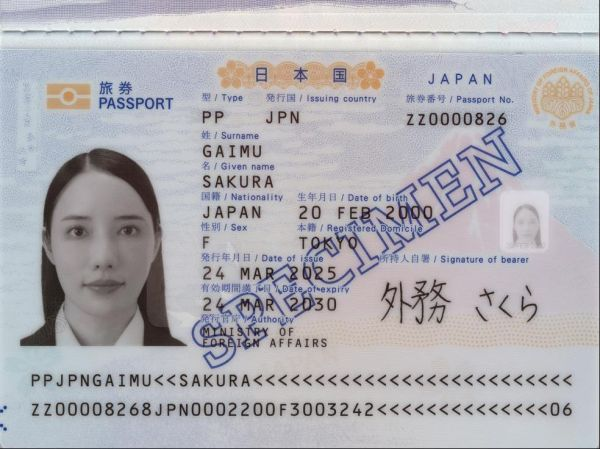


--- Displaying: uploadE.jpg ---



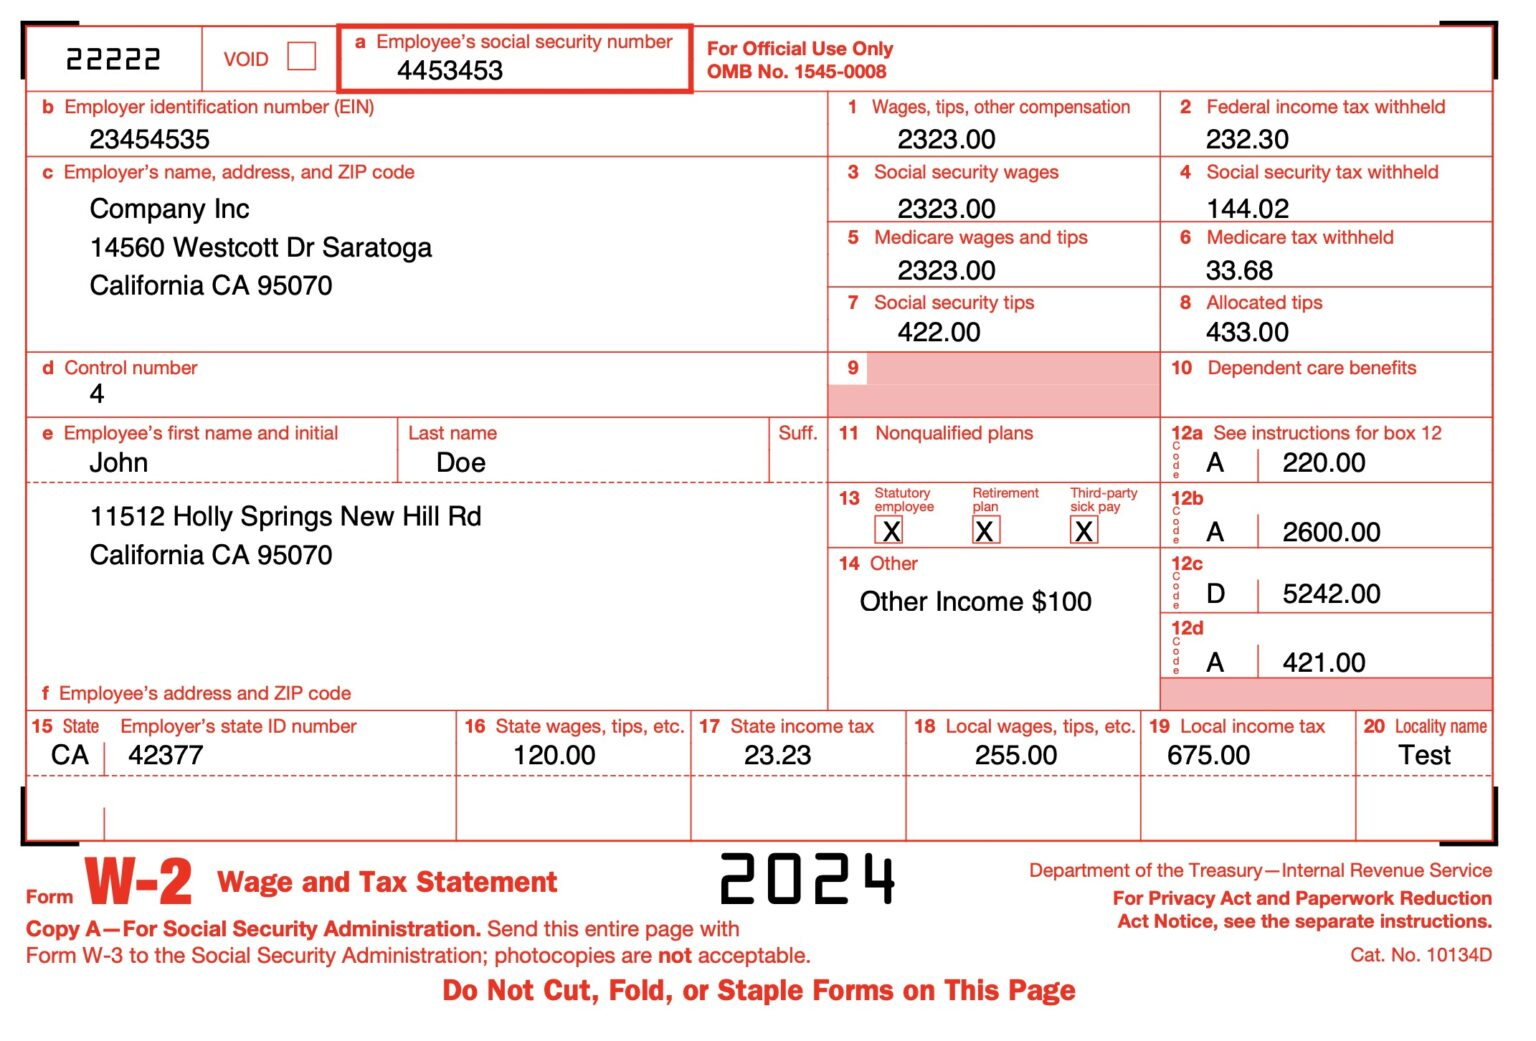

In [7]:
display_directory("input_folder")

<a id="3-2"></a>

### 3.2 Document Categorization Schema

This lab uses **Pydantic** instead of JSON to define schemas. Pydantic provides type validation, rich descriptions via `Field()`, and enum support for constrained values.

ADE accepts both JSON and Pydantic schemas, converting Pydantic to JSON before sending to the API.

In [8]:
# Import Pydantic for schema definition
# ADE accepts pydantic and JSON schemas.
# Exercise 1 used JSON. Exercise 3 uses pydantic.

from enum import Enum
from pydantic import BaseModel, Field
from landingai_ade.lib import pydantic_to_json_schema

class DocumentType(str, Enum):
    ID = "ID"
    W2 = "W2"
    pay_stub = "pay_stub"
    bank_statement = "bank_statement"
    investment_statement = "investment_statement"

    # Descriptions for each value
    def describe(self) -> str:
        descriptions = {
            "ID": "An official government identification such as a "
            "passport or driver's license.",
            "W2": "A year-end W-2 form reporting annual taxable wages "
            "and withholdings.",
            "pay_stub": "A periodic employee earnings statement.",
            "bank_statement": "A checking or savings account statement "
            "with balances and transactions.",
            "investment_statement": "A brokerage or investment account "
            "statement showing holdings, value, and transactions.",
        }
        return descriptions[self.value]

class DocType(BaseModel):
    type: DocumentType = Field(
        description="The type of document being analyzed.",
        title="Document Type",
    )

<a id="3-3"></a>

### 3.3 Define Document-Specific Extraction Schemas

Each document type has different fields of interest. Define separate Pydantic schemas for:
- **ID**: Name, issuer, issue date, identifier
- **W2**: Employee/employer names, year, wages (Box 1)
- **Pay Stub**: Employee/employer names, pay period, gross/net pay
- **Bank Statement**: Account owner, bank name, account number, balance
- **Investment Statement**: Account owner, institution, year, total value

In [9]:
# ---------------------------------------------------------
# Schema for ID
# ---------------------------------------------------------
class IDSchema(BaseModel):
    name: str = Field(description="Full name of the person", 
                      title="Full Name")
    issuer: str = Field(description="The state or country issuing the "
                        "identification.", title="Issuer")
    issue_date: str = Field(description="The issue date for the "
                            "identification.", title="Issue Date")
    identifier: str = Field(description="The unique identifier such as a "
                            "drivers license number or passport number", 
                            title="Identifier")

# ---------------------------------------------------------
# Schema for W2
# ---------------------------------------------------------
class W2Schema(BaseModel):
    employee_name: str = Field(description="The name of the employee.", 
                               title="Employee Name")
    employer_name: str = Field(description="The name of the employer "
                               "organization issuing the W2.", 
                               title="Employer Name")
    w2_year: int = Field(description="The year of the W2 form.", 
                         title="W2 Year")
    wages_box_1: float = Field(description="The total wages shown in box 1 "
                               "of the form", title="Box 1")

# ---------------------------------------------------------
# Schema for Pay Stubs
# ---------------------------------------------------------
class PaymentStubSchema(BaseModel):
    employee_name: str = Field(description="The name of the employee.", 
                               title="Employee Name")
    employer_name: str = Field(description="The name of the employer "
                               "organization.", title="Employer Name")
    pay_period: str = Field(description="The pay period for the stub.",
                            title="Pay Period")
    gross_pay: float = Field(description="The gross pay amount.",
                             title="Gross Pay")
    net_pay: float = Field(description="The net pay amount after "
                           "deductions.", title="Net Pay")
    
# ---------------------------------------------------------
# Schema for Bank Statements
# ---------------------------------------------------------
class BankStatementSchema(BaseModel):
    account_owner: str = Field(description="The name of the account "
                               "owner(s).", title="Account Owner")
    bank_name: str = Field(description="The name of the bank.", 
                           title="Bank Name")
    account_number: str = Field(description="The bank account number.", 
                                title="Account Number")
    end_date: str = Field(description="The ending date for the statement.", 
                          title="End Date")
    balance: float = Field(description="The current balance of the bank "
                           "account.", title="Bank Balance")

# ---------------------------------------------------------
# Schema for Investment Statements
# ---------------------------------------------------------
class InvestmentStatementSchema(BaseModel):
    account_owner: str = Field(description="The name of the account owner(s)."
                               , title="Account Owner")
    institution_name: str = Field(description="The name of the financial "
                                  "institution.", title="Institution Name")
    investment_year: int = Field(description="The year of the investment "
                                 "statement.", title="Investment Year")
    investment_value: float = Field(description="The total value of the "
                                    "account as of the statement end date.", 
                                    title="Investment Balance")

# ---------------------------------------------------------
# Map document types to their corresponding schemas
# ---------------------------------------------------------
schema_per_doc_type = {
    "bank_statement": BankStatementSchema,
    "investment_statement": InvestmentStatementSchema,
    "pay_stub": PaymentStubSchema,
    "ID": IDSchema,
    "W2": W2Schema,
}

In [10]:
# Convert the document type schema to JSON format for API calls
doc_type_json_schema = pydantic_to_json_schema(DocType)

<a id="3-4"></a>

### 3.4 Parse and Categorize Documents

For each document:
1. **Parse** to extract content (using `split="page"` for per-page markdown)
2. **Categorize** using only the first page (sufficient for identification)

In [11]:
input_folder = Path("input_folder")

# Dictionary to store document types and parse results
document_types = {}

# Process each document in the folder
for document in input_folder.iterdir():

    # 🔥 Skip directories so ADE doesn't try to parse them
    if document.is_dir():
        continue
        
    print(f"Processing document: {document.name}")

    # Step 1: Parse the document to extract layout and content
    parse_result: ParseResponse = client.parse(
        document=document,
        split="page",  #Notice that each document is being split by page.
        model="dpt-2-latest"
    )
    print("Parsing completed.")
    print(" ")
    
    # Notice that we only use the first page to determine the document type
    first_page_markdown = parse_result.splits[0].markdown  
    
    # Step 2: Extract document type using the categorization schema
    print("Extracting Document Type...")
    extraction_result: ExtractResponse = client.extract(
        schema=doc_type_json_schema,
        markdown=first_page_markdown
    )
    doc_type = extraction_result.extraction["type"]
    print(f"Document Type Extraction: {doc_type}\n")
    print("       ----------         ")
    print(" ")
    
    # Store results for later use
    document_types[document] = {
        "document_type": doc_type,
        "parse_result": parse_result
    }

Processing document: uploadA.pdf
Parsing completed.
 
Extracting Document Type...
Document Type Extraction: investment_statement

       ----------         
 
Processing document: uploadB.pdf
Parsing completed.
 
Extracting Document Type...
Document Type Extraction: pay_stub

       ----------         
 
Processing document: uploadC.pdf
Parsing completed.
 
Extracting Document Type...
Document Type Extraction: bank_statement

       ----------         
 
Processing document: uploadD.jpeg
Parsing completed.
 
Extracting Document Type...
Document Type Extraction: ID

       ----------         
 
Processing document: uploadE.jpg
Parsing completed.
 
Extracting Document Type...
Document Type Extraction: W2

       ----------         
 


<a id="3-5"></a>

### 3.5 Extract Financial Data Based on Document Type

Now that we know each document's type, we apply the appropriate schema to extract the relevant fields. The schema mapping (`schema_per_doc_type`) ensures each document gets the correct extraction template.

In [12]:
# Dictionary to store extraction results
document_extractions = {}

# Extract financial data from each document using its specific schema
for document, extraction in document_types.items():
    print(f"Processing document: {document.name}")

    # Get the appropriate schema for this document type
    json_schema = pydantic_to_json_schema(
        schema_per_doc_type[extraction["document_type"]]
    )

    # Extract structured data using the schema
    extraction_result: ExtractResponse = client.extract(
        schema=json_schema,
        markdown=extraction["parse_result"].markdown
    )
    print("Detailed Extraction:", extraction_result.extraction)

    # Store extraction results
    document_extractions[document] = {
        "extraction": extraction_result.extraction,
        "extraction_metadata": extraction_result.extraction_metadata,
    }

print(document_extractions)

Processing document: uploadA.pdf
Detailed Extraction: {'account_owner': 'John W. Doe', 'institution_name': 'Fidelity Investments', 'investment_year': 2015, 'investment_value': 274222.2}
Processing document: uploadB.pdf
Detailed Extraction: {'employee_name': 'MICHAEL D BRYAN', 'employer_name': 'VIGAVI GREAT PLAINS', 'pay_period': '03/19/2021', 'gross_pay': 452.43, 'net_pay': 291.9}
Processing document: uploadC.pdf
Detailed Extraction: {'account_owner': 'SUSAN SAMPLE', 'bank_name': 'Royal Bank of Canada', 'account_number': '02782-5094431', 'end_date': 'April 12, 2004', 'balance': 3664.79}
Processing document: uploadD.jpeg
Detailed Extraction: {'name': 'GAIMU SAKURA', 'issuer': 'JAPAN', 'issue_date': '24 MAR 2025', 'identifier': 'ZZ0000826'}
Processing document: uploadE.jpg
Detailed Extraction: {'employee_name': 'John Doe', 'employer_name': 'Company Inc', 'w2_year': 2024, 'wages_box_1': 2323.0}
{PosixPath('input_folder/uploadA.pdf'): {'extraction': {'account_owner': 'John W. Doe', 'instit

<a id="3-6"></a>

### 3.6 Visualize Parsing Results with Bounding Boxes

Visualize all detected chunks for each document to verify parsing quality.

In [13]:
from helper import draw_bounding_boxes_2

# Combine all extraction data
final_extractions = {}

for document, extraction in document_extractions.items():
    final_extractions[document] = {
        **extraction,
        **document_types[document],
    }

# Visualize all parsed chunks for each document
for document, extraction in final_extractions.items():
    print(f"Visualizing document: {document.name}")
    base_path = f"results/{document.stem}"
    os.makedirs(base_path, exist_ok=True)
    draw_bounding_boxes_2(
        extraction["parse_result"].grounding,
        document,
        base_path=base_path
    )

Visualizing document: uploadA.pdf
Annotated image saved to: results/uploadA/page_1_annotated.png
Visualizing document: uploadB.pdf
Annotated image saved to: results/uploadB/page_1_annotated.png
Visualizing document: uploadC.pdf
Annotated image saved to: results/uploadC/page_1_annotated.png
Visualizing document: uploadD.jpeg
Annotated image saved to: page_annotated.png
Visualizing document: uploadE.jpg
Annotated image saved to: page_annotated.png


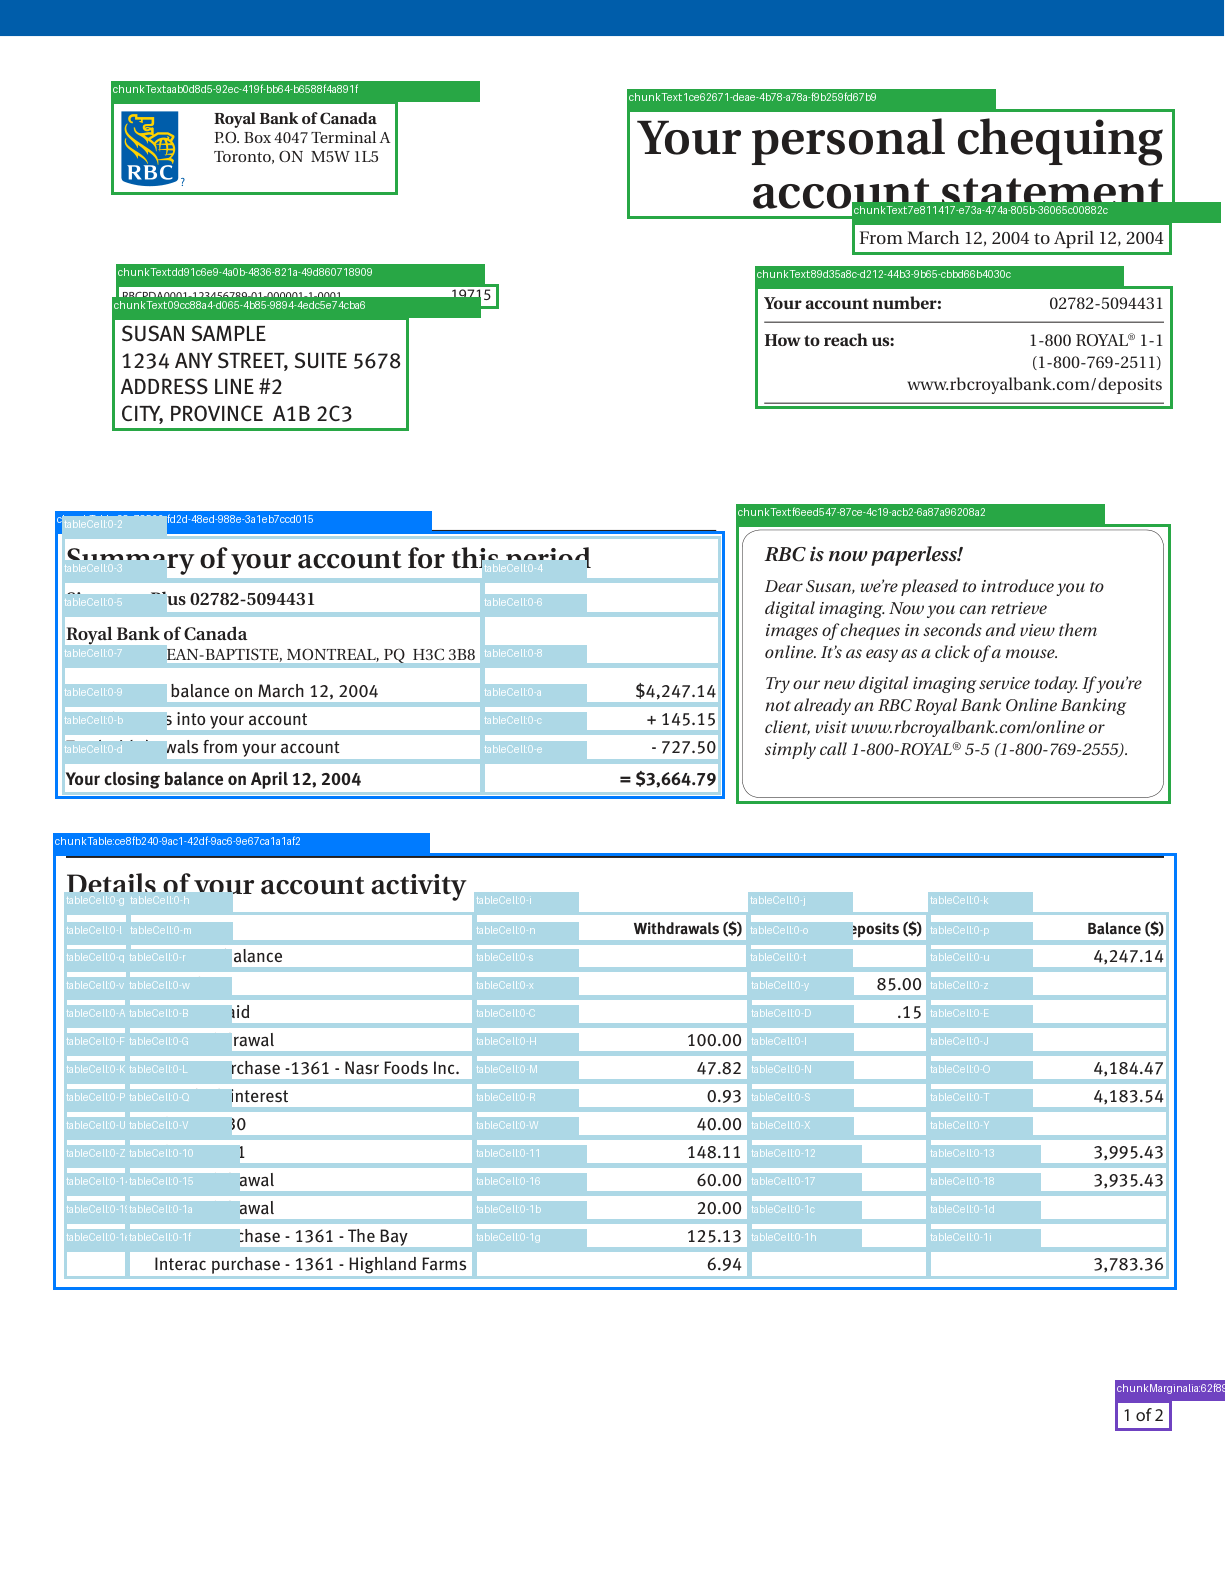

In [14]:
PILImage.open(f"results/uploadC/page_1_annotated.png")

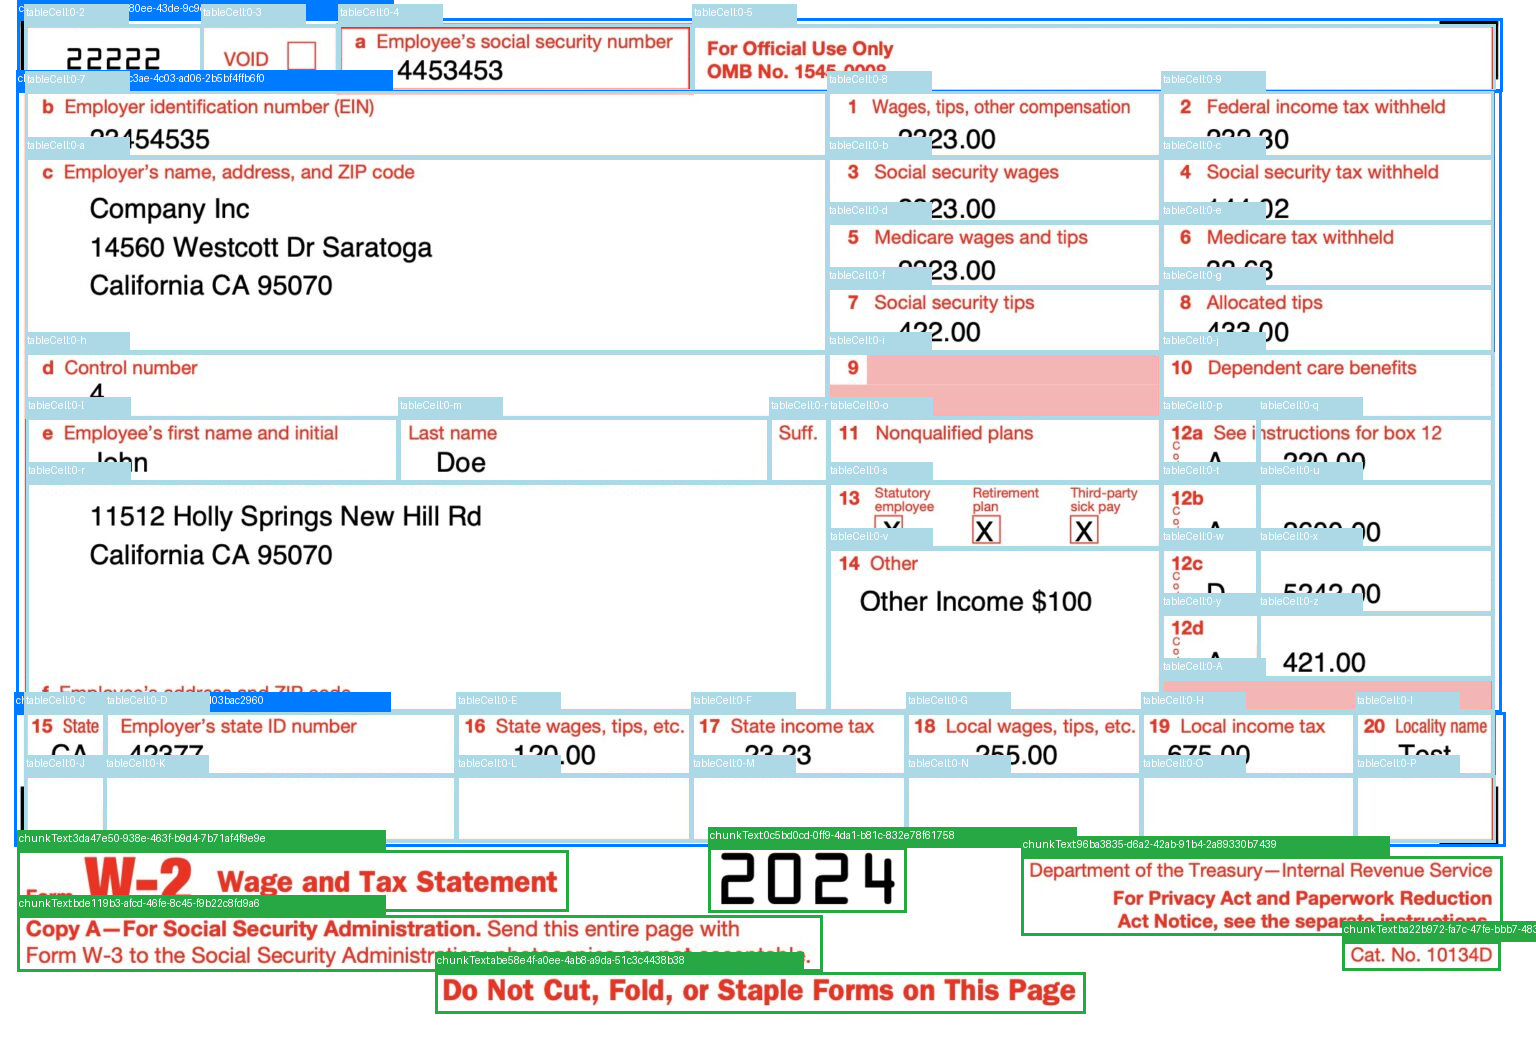

In [15]:
PILImage.open(f"results/uploadE/page_1_annotated.png")

<a id="3-7"></a>

### 3.7 Visualize Extracted Fields Only

For human-in-the-loop systems, highlight only the extracted fields to show reviewers where values originated.

In [16]:
for document, extraction in final_extractions.items():
    print(f"Visualizing extracted fields for: {document.name}")
    base_path = f"results_extracted/{document.stem}"

    parse_result = extraction["parse_result"]
    document_grounds = {}

    for label, metadata_value in extraction["extraction_metadata"].items():
        chunk_id = metadata_value["references"][0]
        grounding = parse_result.grounding[chunk_id]
        document_grounds[chunk_id] = grounding

    draw_bounding_boxes_2(
        document_grounds,  # dict of chunk_id -> grounding
        document,
        base_path=base_path
    )

Visualizing extracted fields for: uploadA.pdf
Annotated image saved to: results_extracted/uploadA/page_1_annotated.png
Visualizing extracted fields for: uploadB.pdf
Annotated image saved to: results_extracted/uploadB/page_1_annotated.png
Visualizing extracted fields for: uploadC.pdf
Annotated image saved to: results_extracted/uploadC/page_1_annotated.png
Visualizing extracted fields for: uploadD.jpeg
Annotated image saved to: page_annotated.png
Visualizing extracted fields for: uploadE.jpg
Annotated image saved to: page_annotated.png


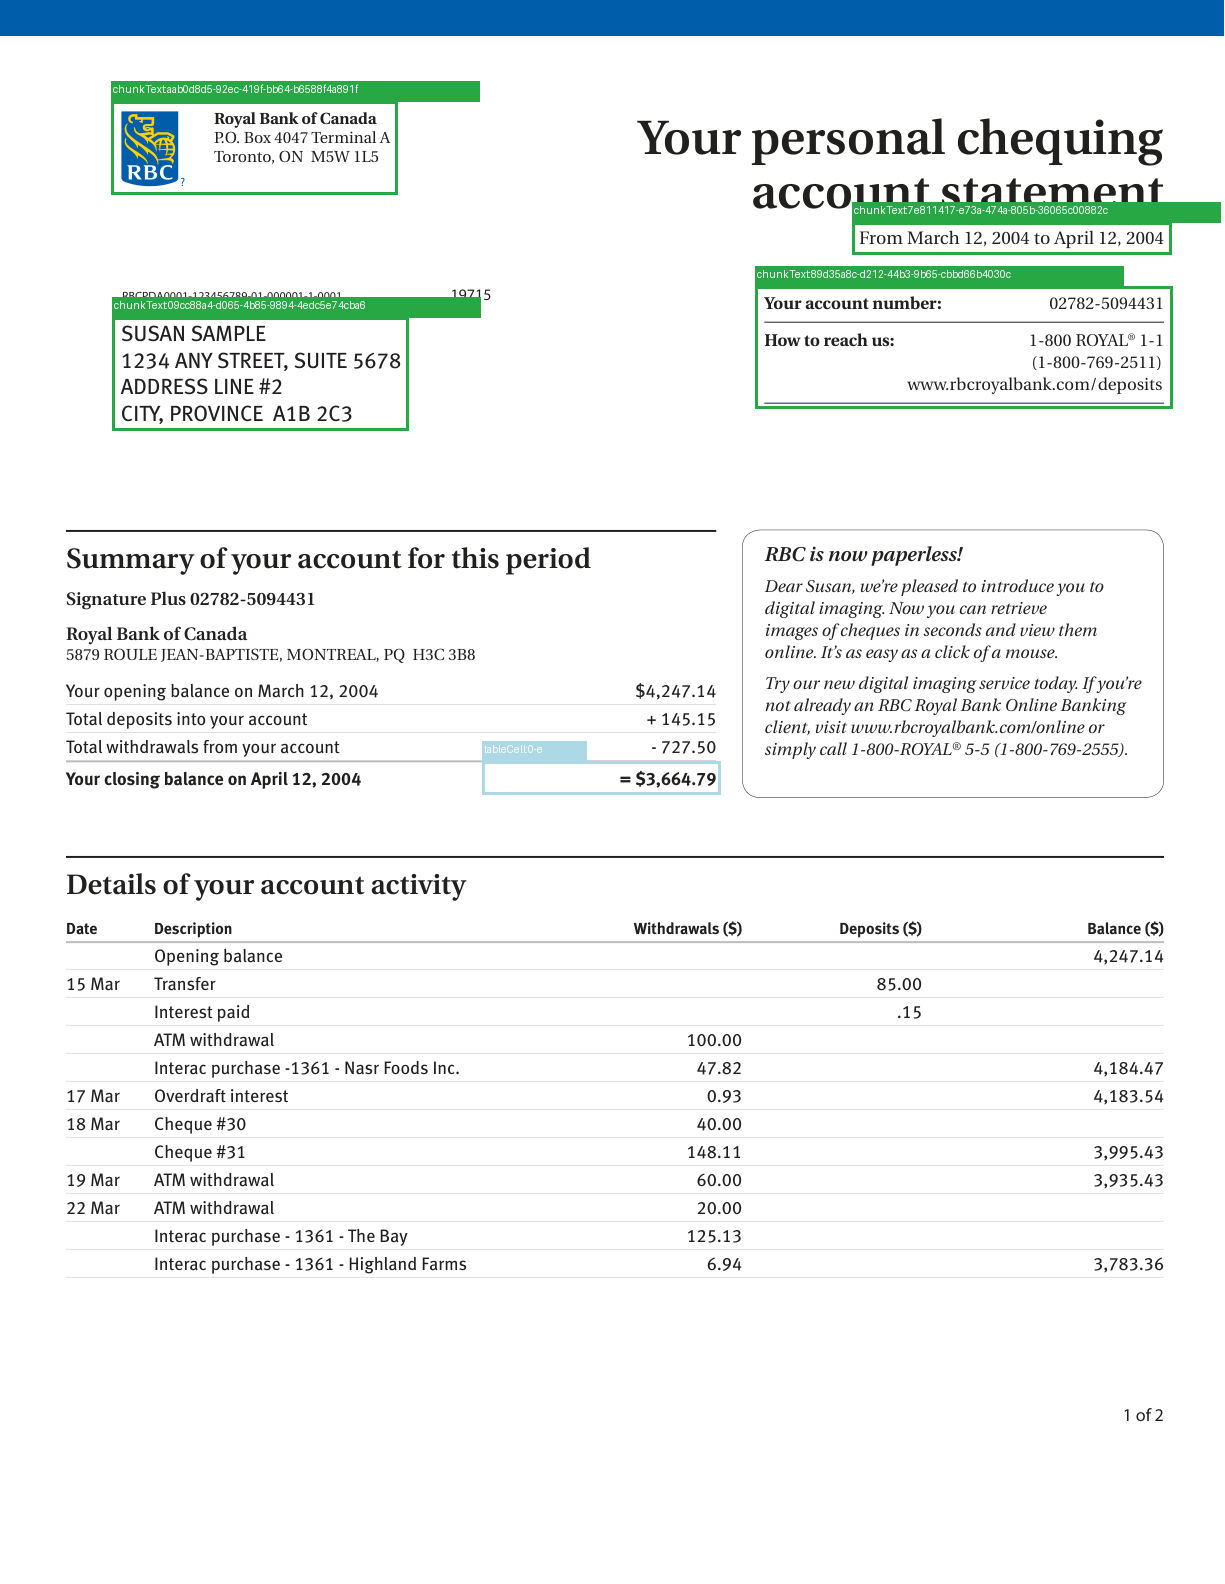

In [17]:
PILImage.open(f"results_extracted/uploadC/page_1_annotated.png")

<a id="3-8"></a>

### 3.8 Create a Final Dataframe

Consolidate all extracted fields into a summary dataframe for a complete view of applicant information.

In [18]:
import pandas as pd

# Collect all the fields into a summary dataframe
rows = []

for document, info in document_extractions.items():
    extraction = info["extraction"]
    doc_type = document_types[document]["document_type"]  # from your classification step

    input_folder = document.parent.name
    document_name = document.name

    for field, value in extraction.items():
        rows.append({
            "applicant_folder": input_folder,
            "document_name": document_name,
            "document_type": doc_type,
            "field": field,
            "value": value,
        })

df = pd.DataFrame(rows)

df

,applicant_folder,document_name,document_type,field,value
0,input_folder,uploadA.pdf,investment_statement,account_owner,John W. Doe
1,input_folder,uploadA.pdf,investment_statement,institution_name,Fidelity Investments
2,input_folder,uploadA.pdf,investment_statement,investment_year,2015
3,input_folder,uploadA.pdf,investment_statement,investment_value,274222.2
4,input_folder,uploadB.pdf,pay_stub,employee_name,MICHAEL D BRYAN
5,input_folder,uploadB.pdf,pay_stub,employer_name,VIGAVI GREAT PLAINS
6,input_folder,uploadB.pdf,pay_stub,pay_period,03/19/2021
7,input_folder,uploadB.pdf,pay_stub,gross_pay,452.43
8,input_folder,uploadB.pdf,pay_stub,net_pay,291.9
9,input_folder,uploadC.pdf,bank_statement,account_owner,SUSAN SAMPLE


<a id="3-9"></a>

### 3.9 Validation Logic

Apply business logic to validate the submission:
- **Name matching**: Verify all documents belong to the same person
- **Year verification**: Check all documents are from recent years
- **Asset totals**: Calculate the applicant's total net worth

**Check 1: Name Matching**

Verify that all name fields across documents match to catch mismatched submissions.

In [19]:
# Logic check to determine whether the five name fields extracted 
# from five documents match each other.

name_fields = {"account_owner", "employee_name", "name"}
df_names = df[df["field"].isin(name_fields)].copy()
all_names_match = df_names["value"].nunique() == 1

if all_names_match:
    print("✅ All 5 name fields match!")
else:
    print("❌ The name fields do NOT match.")
    print("Values found:")
    print(df_names[["document_name", "field", "value"]])

❌ The name fields do NOT match.
Values found:
   document_name          field            value
0    uploadA.pdf  account_owner      John W. Doe
4    uploadB.pdf  employee_name  MICHAEL D BRYAN
9    uploadC.pdf  account_owner     SUSAN SAMPLE
14  uploadD.jpeg           name     GAIMU SAKURA
18   uploadE.jpg  employee_name         John Doe


**Check 2: Document Year**

Loan applications require recent documents. Extract and verify the year from each document.

In [20]:
# Logic to extract and check the year associated with each document

import re

# 1. Fields that may contain a year
year_fields = {
    "w2_year",
    "investment_year",
    "issue_date",
    "end_date",
    "pay_period",
}

# 2. Helper to pull a 4-digit year out of a string/number
def extract_year(value):
    """
    Return a 4-digit year (1900–2099) from a value, or None if none found.
    """
    if value is None:
        return None
    match = re.search(r"\b(19|20)\d{2}\b", str(value))
    return int(match.group(0)) if match else None


# 3. Build a table of years per document
year_rows = []

for doc_name in df["document_name"].unique():
    doc_df = df[df["document_name"] == doc_name]

    # Only rows whose field is one of our year-related fields
    doc_year_fields = doc_df[doc_df["field"].isin(year_fields)]

    for _, row in doc_year_fields.iterrows():
        year_value = extract_year(row["value"])
        year_rows.append({
            "document_name": doc_name,
            "field": row["field"],
            "value": row["value"],
            "year_extracted": year_value,
        })

df_years = pd.DataFrame(year_rows)

print("Per-document year info:")
print(df_years)

Per-document year info:
  document_name            field           value  year_extracted
0   uploadA.pdf  investment_year            2015            2015
1   uploadB.pdf       pay_period      03/19/2021            2021
2   uploadC.pdf         end_date  April 12, 2004            2004
3  uploadD.jpeg       issue_date     24 MAR 2025            2025
4   uploadE.jpg          w2_year            2024            2024


**Check 3: Total Assets**

Sum all bank and investment balances to determine loan eligibility.

In [21]:
# Logic to sum all bank balances and all investment balances from your extraction

# Define fields
bank_balance_field = "balance"
investment_balance_field = "investment_value"

# Filter rows
df_bank = df[df["field"] == bank_balance_field].copy()
df_invest = df[df["field"] == investment_balance_field].copy()

# Ensure numeric
df_bank["value"] = pd.to_numeric(df_bank["value"], errors="coerce")
df_invest["value"] = pd.to_numeric(df_invest["value"], errors="coerce")

# Compute totals
total_bank = df_bank["value"].sum()
total_investments = df_invest["value"].sum()
total_assets = total_bank + total_investments

# Print
print(f"Total Bank Balances: ${total_bank:,.2f}")
print(f"Total Investment Balances: ${total_investments:,.2f}")
print(f"Total Assets: ${total_assets:,.2f}")

Total Bank Balances: $3,664.79
Total Investment Balances: $274,222.20
Total Assets: $277,886.99


<a id="4"></a>

## 4. Summary

In this lab, you built a document processing pipeline for loan automation:

| Step | Description |
|------|-------------|
| **Parse** | Convert documents to structured markdown with chunks and grounding |
| **Categorize** | Identify document types from the first page according to a categorization schema |
| **Extract** | Apply Pydantic schemas specific to document type |
| **Visualize** | Display bounding boxes for all chunks  |
| **Validate** | Apply data validation to fields (eg name matching, year checks, asset totals) |

Our approach applies to other scenarios such as insurance claims, healthcare records, legal briefings, and payroll processing.

In the next lesson, you'll use ADE for RAG (Retrieval-Augmented Generation) applications.